In [1]:
import numpy as np 
from scipy.optimize import minimize
import pandas as pd

In [2]:
file_path = 'data/returns.csv'
rf_rate = 0.0653

In [3]:
try:
    all_returns = pd.read_csv(file_path, index_col=0, parse_dates=True)
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found.")
    print("Please make sure your 'returns.csv' file is inside a 'data' folder.")
    raise

In [4]:
tickers = all_returns.columns[:5].tolist()
stock_returns = all_returns[tickers]

In [5]:
stock_returns.head()

,OLAELEC,WHIRLPOOL,SAGILITY,RAMCOCEM,TATACHEM
date,,,,,
2025-10-10 00:00:00+05:30,-0.010010,0.021958,0.035114,0.010312,-0.003317
2025-10-09 00:00:00+05:30,-0.020310,-0.017588,-0.006013,0.009568,-0.002040
2025-10-08 00:00:00+05:30,-0.026581,-0.024600,0.006236,-0.007085,-0.015411
2025-10-07 00:00:00+05:30,-0.000190,0.008499,0.012816,0.026397,-0.005139
2025-10-06 00:00:00+05:30,-0.025703,0.003301,0.017118,-0.010410,0.001350


In [6]:
mean_returns = stock_returns.mean()
cov_matrix = stock_returns.cov()

In [7]:
def portf_stats(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, std_dev

def neg_sharpe(weights, mean_returns, cov_matrix, rf_rate):
    returns, std_dev = portf_stats(weights, mean_returns, cov_matrix)
    sharpe_ratio = (returns-rf_rate)/std_dev
    return -sharpe_ratio

def portf_volatility(weights, mean_returns, cov_matrix):
    return portf_stats(weights, mean_returns, cov_matrix)[1]

In [8]:
def tangency_portfolio(mean_returns, cov_matrix, rf_rate):
    numAssets = len(mean_returns)
    args = (mean_returns, cov_matrix, rf_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(numAssets))
    initial_guess = numAssets * [1. / numAssets]
    res = minimize(
        neg_sharpe,
        initial_guess,
        args,
        method = 'SLSQP',
        constraints=constraints,
        bounds=bounds
    )
    if not res.success:
        raise BaseException(res.message)
    return res

In [9]:
tangency_res = tangency_portfolio(mean_returns, cov_matrix, rf_rate)
tangency_weights = tangency_res.x
tangency_return, tangency_vol = portf_stats(tangency_weights, mean_returns, cov_matrix)
tangency_sharpe = (tangency_return - rf_rate) / tangency_vol

In [10]:
def min_var_portfolio(mean_returns, cov_matrix):
    numAssets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(numAssets))
    initial_guess = numAssets * [1. / numAssets]
    res = minimize(
        portf_volatility,
        initial_guess,
        args=args,
        method = 'SLSQP',
        constraints=constraints,
        bounds=bounds
    )
    if not res.success:
        raise BaseException(res.message)
    return res

In [11]:
def efficient_portfolio(mean_returns, cov_matrix, target_returns):
    numAssets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type' : 'eq', 'fun': lambda x: portf_stats(x, mean_returns, cov_matrix)[0] - target_returns}, 
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(numAssets))
    initial_guess = numAssets * [1. / numAssets]
    res = minimize(
        portf_volatility,
        initial_guess,
        args=args,
        method = 'SLSQP',
        constraints=constraints,
        bounds=bounds
    )
    return res

In [12]:
min_var_result = min_var_portfolio(mean_returns, cov_matrix)
min_var_weights = min_var_result.x
min_var_return, min_var_vol = portf_stats(min_var_weights, mean_returns, cov_matrix)

In [13]:
index_ticker = all_returns.columns[-1]
index_returns = all_returns[index_ticker]

In [14]:
def getBenchmarkPerformance(index_returns, rf_rate):
    meanReturn = index_returns.mean() * 252
    stdDev = index_returns.std() * np.sqrt(252)
    sharpe = (meanReturn - rf_rate) / stdDev
    return meanReturn, stdDev, sharpe

In [15]:
target_returns = np.linspace(mean_returns.min()*252, mean_returns.max()*252, 50)
frontier_vols = []
frontier_rets = []

for tr in target_returns:
    res = efficient_portfolio(mean_returns, cov_matrix, tr)
    vol = portf_volatility(res.x, mean_returns, cov_matrix)
    frontier_vols.append(vol)
    frontier_rets.append(tr)


In [16]:
# Create CAL line (Capital Allocation Line)
cal_vols = np.linspace(0, max(frontier_vols), 50)
cal_rets = rf_rate + ((tangency_return - rf_rate) / tangency_vol) * cal_vols

In [17]:
import matplotlib.pyplot as plt

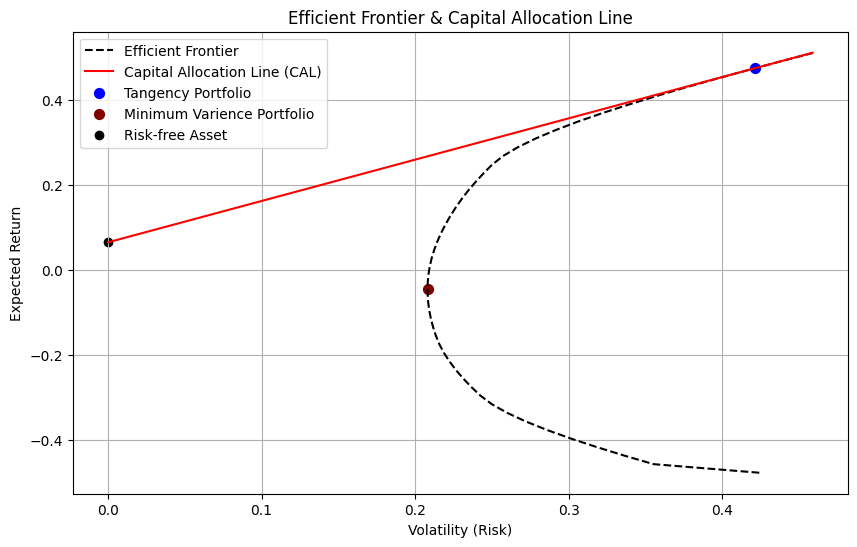

In [18]:
plt.figure(figsize=(10,6))
plt.plot(frontier_vols, frontier_rets, 'k--', label='Efficient Frontier')
plt.plot(cal_vols, cal_rets, 'r-', label='Capital Allocation Line (CAL)')
plt.scatter(tangency_vol, tangency_return, color='blue', marker='.', s=200, label='Tangency Portfolio')
plt.scatter(min_var_vol, min_var_return, color='maroon', marker='.', s=200, label='Minimum Varience Portfolio')
plt.scatter(0, rf_rate, color='black', marker='o', label='Risk-free Asset')

plt.title('Efficient Frontier & Capital Allocation Line')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


In [19]:

df_weights = pd.DataFrame({
    'Minimum Variance': min_var_weights,
    'Tangency': tangency_weights
}, index=tickers)

df_weights_pct = (df_weights * 100).round(2)

print("Weights (fractions):")
print(df_weights)
print("\nWeights (percent):")
print(df_weights_pct)

Weights (fractions):
           Minimum Variance      Tangency
OLAELEC            0.002814  1.211638e-16
WHIRLPOOL          0.113272  7.587632e-16
SAGILITY           0.079572  9.066658e-01
RAMCOCEM           0.389669  9.333416e-02
TATACHEM           0.414674  0.000000e+00

Weights (percent):
           Minimum Variance  Tangency
OLAELEC                0.28      0.00
WHIRLPOOL             11.33      0.00
SAGILITY               7.96     90.67
RAMCOCEM              38.97      9.33
TATACHEM              41.47      0.00


In [20]:
print("Annual returns of the tancency portfolio:", tangency_return )
print("Annual volatility of the tancency portfolio:", tangency_vol )

print("Annual returns of the minimum variance portfolio:", min_var_return )
print("Annual volatility of the minimum variance portfolio:", min_var_vol )

Annual returns of the tancency portfolio: 0.4751505755322497
Annual volatility of the tancency portfolio: 0.4209682155446426
Annual returns of the minimum variance portfolio: -0.04511135895064498
Annual volatility of the minimum variance portfolio: 0.20799927893008954
